In [12]:
from faker import Faker
from babel.dates import format_date
import random
fake = Faker()
fake.seed(123)
random.seed(321)

# 各种日期格式
FORMATS = ['short',
           'medium',
           'long',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'd MMM YYY',
           'd MMMM YYY',
           'dd MMM YYY',
           'd MMM, YYY',
           'd MMMM, YYY',
           'dd, MMM YYY',
           'd MM YY',
           'd MMMM YYY',
           'MMMM d YYY',
           'MMMM d, YYY',
           'dd.MM.YY']

# LOCALES = ['en_US']

In [13]:
def load_date():
    # 加载一些日期数据
    dt = fake.date_object()
    human_readable = format_date(dt, format=random.choice(FORMATS),
                                 locale='en_US')
    # 使用随机选取的格式，生成日期
    human_readable = human_readable.lower().replace(',','')
    machine_readable = dt.isoformat()
    return human_readable, machine_readable, dt

test_date = load_date()

In [14]:
from tqdm import tqdm # 显示进度条
def load_dateset(num_of_data):
    human_vocab = set()
    machine_vocab = set()
    dataset = []
    Tx = 30 # 日期最大长度
    for i in tqdm(range(num_of_data)):
        h, m, _ = load_date()
        if h is not None:
            dataset.append((h, m))
            human_vocab.update(tuple(h))
            machine_vocab.update(tuple(m))
    human = dict(zip(sorted(human_vocab)+['<unk>', '<pad>'],
                     list(range(len(human_vocab)+2))))
    # x 字符：idx 的映射
    inv_machine = dict(enumerate(sorted(machine_vocab)))
    # idx ： y 字符
    machine = {v : k for k, v in inv_machine.items()}
    # y 字符 ： idx
    return dataset, human, machine, inv_machine

m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dateset(m)

100%|██████████| 10000/10000 [00:00<00:00, 17883.24it/s]


In [15]:
import numpy as np
from keras.utils import to_categorical

def string_to_int(string, length, vocab):
    string = string.lower().replace(',','')
    if len(string) > length: # 长了，截断
        string = string[:length]
    rep = list(map(lambda x : vocab.get(x, '<unk>'), string))
    # 对string里每个char 使用 匿名函数 获取映射的id，没有的话，使用unk的id，map返回迭代器，转成list
    if len(string) < length:
        rep += [vocab['<pad>']]*(length-len(string))
        # 长度不够，加上 pad 的 id
    return rep # 返回 [ids,...]

def process_data(dataset, human_vocab, machine_vocab, Tx, Ty):
    X,Y = zip(*dataset)
    print("处理前 X：{}".format(X))
    print("处理前 Y：{}".format(Y))
    X = np.array([string_to_int(date, Tx, human_vocab) for date in X])
    Y = [string_to_int(date, Ty, machine_vocab) for date in Y]
    print("处理后 X的shape：{}".format(X.shape))
    print("处理后 Y: {}".format(Y))

    Xoh = np.array(list(map(lambda x : to_categorical(x, num_classes=len(human_vocab)), X)))
    Yoh = np.array(list(map(lambda x : to_categorical(x, num_classes=len(machine_vocab)), Y)))
    return X, np.array(Y), Xoh, Yoh
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = process_data(dataset, human_vocab, machine_vocab, Tx, Ty)

处理前 X：('sunday march 20 1988', 'monday december 8 1975', 'thursday september 18 1997', '21 february 1988', '30 april 1977', 'sunday august 6 1972', '20.10.95', 'wednesday june 28 2006', '7 04 08', '9 august 1992', '11 mar 1993', 'july 14 1973', '12 nov 1980', '11 march 1979', 'saturday december 12 1992', '3/4/08', '18 sep 1992', 'sunday october 1 2017', '7 sep 1986', 'feb 22 1981', 'wednesday february 11 1970', '09 sep 1999', '18 dec 1975', 'wednesday september 1 2010', 'september 12 1995', 'thursday october 3 1974', 'saturday june 13 1970', 'thursday june 20 1991', 'october 25 2019', '5 jul 2000', '11 december 1976', '26 dec 1972', 'saturday april 24 1976', 'may 26 2015', 'tuesday september 4 1979', '4 august 1978', '12.06.71', 'thursday november 9 1989', 'april 22 1999', 'thursday january 8 2009', '15.06.02', '21 january 1988', 'saturday december 8 2001', 'sunday july 2 1972', '6 october 1990', 'may 16 1993', 'saturday july 2 2005', 'wednesday november 13 2002', '29 january 1984', 't

In [16]:
print(X.shape)
print(Y.shape)
print(Xoh.shape)
print(Yoh.shape)

(10000, 30)
(10000, 10)
(10000, 30, 37)
(10000, 10, 11)


In [17]:
from keras import backend as K
def softmax(x, axis=1):
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e/s
    else:
        raise ValueError('维度不对，不能是1维')

# prob = softmax(np.array([[1]]))

In [18]:
from keras.layers import RepeatVector, LSTM, Concatenate, \
    Dense, Activation, Dot, Input, Bidirectional

repeator = RepeatVector(Tx) # 重复 Tx 次
# 重复器
# Input shape:
#     2D tensor of shape `(num_samples, features)`.
#
# Output shape:
#     3D tensor of shape `(num_samples, n, features)`.
concator = Concatenate(axis=-1) # 拼接器
densor1 = Dense(10, activation='tanh') #
densor2 = Dense(1, activation='relu')
activator = Activation(softmax, name='attention_weights')
dotor = Dot(axes=1)


Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_first (InputLayer)        [(None, 30, 37)]     0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 30, 64)       17920       input_first[0][0]                
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_6[0][0]          

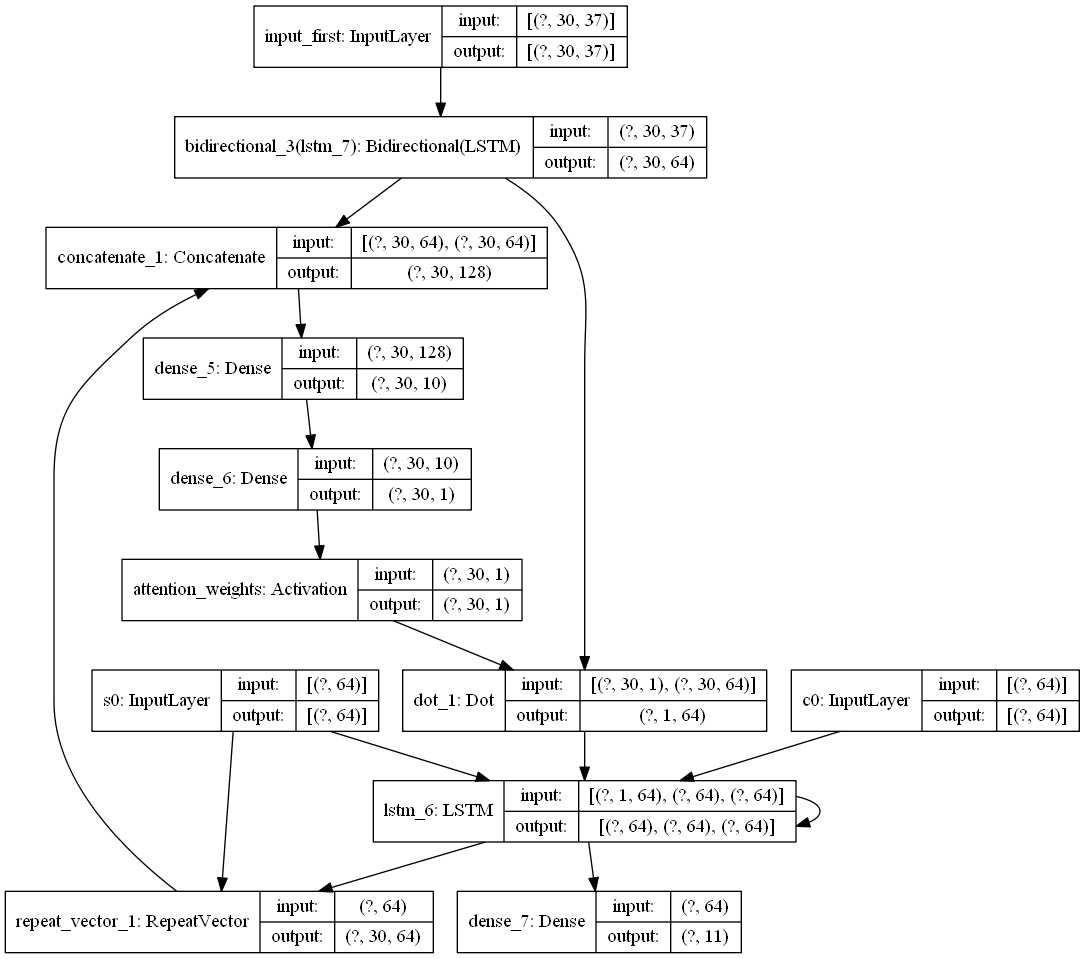

In [19]:
def one_step_attention(h, s_prev):
    s_prev = repeator(s_prev) #
    concat = concator([h, s_prev])
    e = densor1(concat)
    energies = densor2(e)
    alphas = activator(energies)
    context = dotor([alphas, h])
    return context

# 解码器
n_h = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state=True)
output_layer = Dense(len(machine_vocab), activation=softmax)

from keras.models import Model
def model(Tx, Ty, n_h, n_s, human_vocab_size, machine_vocab_size):
    X = Input(shape=(Tx,human_vocab_size), name='input_first')
    s0 = Input(shape=(n_s,),name='s0')
    c0 = Input(shape=(n_s,),name='c0')
    s = s0
    c = c0
    outputs = []
    h = Bidirectional(LSTM(n_h, return_sequences=True))(X)
    for t in range(Ty):
        context = one_step_attention(h, s)
        s, _, c = post_activation_LSTM_cell(context, initial_state=[s,c])
        out = output_layer(s)
        outputs.append(out)
    model = Model(inputs=[X,s0,c0], outputs=outputs)
    return model
model = model(Tx,Ty,n_h,n_s,len(human_vocab), len(machine_vocab))
model.summary()

from keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True,rankdir='TB')

In [23]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.005, decay=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy',
              metrics=['accuracy'])
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0, 1))
history = model.fit([Xoh, s0, c0], outputs,
                    epochs=10, batch_size=128,
                    validation_split=0.1)

Epoch 1/10
71/71 [==============================] - 9s 123ms/step - loss: 10.2456 - dense_7_loss: 0.1098 - dense_7_1_loss: 0.1075 - dense_7_2_loss: 0.7570 - dense_7_3_loss: 1.8773 - dense_7_4_loss: 0.7274 - dense_7_5_loss: 0.4799 - dense_7_6_loss: 1.9206 - dense_7_7_loss: 0.7091 - dense_7_8_loss: 1.2641 - dense_7_9_loss: 2.2930 - dense_7_accuracy: 0.9636 - dense_7_1_accuracy: 0.9673 - dense_7_2_accuracy: 0.7388 - dense_7_3_accuracy: 0.4350 - dense_7_4_accuracy: 0.9012 - dense_7_5_accuracy: 0.8331 - dense_7_6_accuracy: 0.3978 - dense_7_7_accuracy: 0.8888 - dense_7_8_accuracy: 0.5449 - dense_7_9_accuracy: 0.2691 - val_loss: 4.8827 - val_dense_7_loss: 0.0575 - val_dense_7_1_loss: 0.0484 - val_dense_7_2_loss: 0.4081 - val_dense_7_3_loss: 0.9115 - val_dense_7_4_loss: 0.0137 - val_dense_7_5_loss: 0.1171 - val_dense_7_6_loss: 1.0719 - val_dense_7_7_loss: 0.0075 - val_dense_7_8_loss: 0.6328 - val_dense_7_9_loss: 1.6143 - val_dense_7_accuracy: 0.9840 - val_dense_7_1_accuracy: 0.9890 - val_dense

Index(['loss', 'dense_7_loss', 'dense_7_1_loss', 'dense_7_2_loss',
       'dense_7_3_loss', 'dense_7_4_loss', 'dense_7_5_loss', 'dense_7_6_loss',
       'dense_7_7_loss', 'dense_7_8_loss', 'dense_7_9_loss',
       'dense_7_accuracy', 'dense_7_1_accuracy', 'dense_7_2_accuracy',
       'dense_7_3_accuracy', 'dense_7_4_accuracy', 'dense_7_5_accuracy',
       'dense_7_6_accuracy', 'dense_7_7_accuracy', 'dense_7_8_accuracy',
       'dense_7_9_accuracy', 'val_loss', 'val_dense_7_loss',
       'val_dense_7_1_loss', 'val_dense_7_2_loss', 'val_dense_7_3_loss',
       'val_dense_7_4_loss', 'val_dense_7_5_loss', 'val_dense_7_6_loss',
       'val_dense_7_7_loss', 'val_dense_7_8_loss', 'val_dense_7_9_loss',
       'val_dense_7_accuracy', 'val_dense_7_1_accuracy',
       'val_dense_7_2_accuracy', 'val_dense_7_3_accuracy',
       'val_dense_7_4_accuracy', 'val_dense_7_5_accuracy',
       'val_dense_7_6_accuracy', 'val_dense_7_7_accuracy',
       'val_dense_7_8_accuracy', 'val_dense_7_9_accuracy'],
  

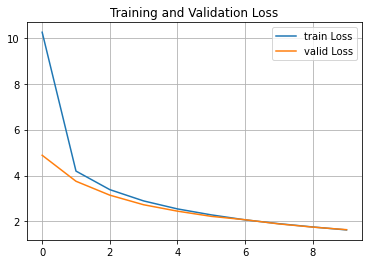

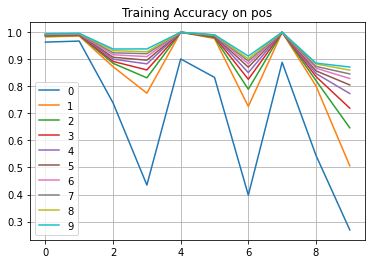

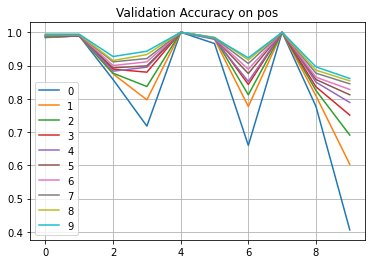

In [35]:
from matplotlib import pyplot as plt
import pandas as pd
his = pd.DataFrame(history.history)
print(his.columns)
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='train Loss')
plt.plot(val_loss, label='valid Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

col_train_acc = (
 'dense_7_accuracy', 'dense_7_1_accuracy', 'dense_7_2_accuracy',
 'dense_7_3_accuracy', 'dense_7_4_accuracy', 'dense_7_5_accuracy',
 'dense_7_6_accuracy', 'dense_7_7_accuracy', 'dense_7_8_accuracy',
 'dense_7_9_accuracy')
col_test_acc = (
 'val_dense_7_accuracy', 'val_dense_7_1_accuracy',
 'val_dense_7_2_accuracy', 'val_dense_7_3_accuracy',
 'val_dense_7_4_accuracy', 'val_dense_7_5_accuracy',
 'val_dense_7_6_accuracy', 'val_dense_7_7_accuracy',
 'val_dense_7_8_accuracy', 'val_dense_7_9_accuracy')
train_acc = pd.DataFrame(history.history[c] for c in col_train_acc)
test_acc = pd.DataFrame(history.history[c] for c in col_test_acc)

train_acc.plot()
plt.title('Training Accuracy on pos')
plt.legend()
plt.grid()
plt.show()

test_acc.plot()
plt.title('Validation Accuracy on pos')
plt.legend()
plt.grid()
plt.show()

In [36]:
s0 = np.zeros((1, n_s))
c0 = np.zeros((1, n_s))
test_data,_,_,_ = load_dateset(10)
for x,y in test_data:
    print(x + " ==> " +y)
for x,_ in test_data:
    source = string_to_int(x, Tx, human_vocab)
    source = np.array(list(map(lambda a : to_categorical(a, num_classes=len(human_vocab)), source)))
    source = source[np.newaxis, :]
    pred = model.predict([source, s0, c0])
    pred = np.argmax(pred, axis=-1)
    output = [inv_machine_vocab[int(i)] for i in pred]
    print('source:',x)
    print('output:',''.join(output))

100%|██████████| 10/10 [00:00<00:00, 716.18it/s]


18 april 2014 ==> 2014-04-18
saturday august 22 1998 ==> 1998-08-22
october 22 1995 ==> 1995-10-22
thursday february 29 1996 ==> 1996-02-29
wednesday october 17 1979 ==> 1979-10-17
7 12 73 ==> 1973-12-07
9/30/01 ==> 2001-09-30
22 may 2001 ==> 2001-05-22
7 march 1979 ==> 1979-03-07
19 feb 2013 ==> 2013-02-19
source: 18 april 2014
output: 2014-04-18
source: saturday august 22 1998
output: 1998-08-22
source: october 22 1995
output: 1995-12-22
source: thursday february 29 1996
output: 1996-02-29
source: wednesday october 17 1979
output: 1979-10-17
source: 7 12 73
output: 1973-02-07
source: 9/30/01
output: 2001-05-00
source: 22 may 2001
output: 2011-05-22
source: 7 march 1979
output: 1979-03-07
source: 19 feb 2013
output: 2013-02-19
